Importing

In [1]:
import torch
from torch.optim import Adam
from torch.optim import LBFGS
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
sns.set_style('darkgrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Physical System to Model: 1D Deformation, Linear Isotropic

In [2]:
#DBC, positions and displacments
x_pos = [(0.0)]
x_disp = [(0.0)]
x_pos, x_disp = torch.tensor(x_pos).requires_grad_(True).to(device),torch.tensor(x_disp).requires_grad_(True).to(device)
DBC = [x_pos,x_disp]

#NBC, Scalar Traction Force, Normal Vector, and Position.
T_hat = [(2.0)]
n_hat = [(1.0)]
T_pos = [(10.0)]
T_hat, n_hat, T_pos = torch.tensor(T_hat).requires_grad_(True).to(device),torch.tensor(n_hat).requires_grad_(True).to(device),torch.tensor(T_pos).requires_grad_(True).to(device)
NBC = [T_hat,n_hat,T_pos]

# Physical Parameters, E = Youngs Modulus, v = Poisson's ratio.
# Rubber
p = dict(E=4.0, v=0.45)
#Stiffness mat, 1D
C = 1.0/p['E']
C = torch.tensor(C).view(1).requires_grad_(True).to(device)

Creating vector for Training Range

In [3]:
x = 10
# Range of t to be modelled [0,10]
train = torch.linspace(0,x,64).view(-1,1).requires_grad_(True)
train = train.to(device)

Numerical Solution?

In [4]:
#Sol?

Plotting

In [25]:
def plot_comp():
    x_plot = np.linspace(0, x, 10)
    plot_input = torch.linspace(0,x,10).view(-1,1).requires_grad_(True)
    plot_input = plot_input.to(device)
    pred = model(plot_input)
    _, loss_absolute = loss_fn(model, plot_input)
    pred_plot = torch.reshape(pred, (-1,)).cpu().detach().numpy() + x_plot

    plt.scatter(x_plot,np.ones_like(x_plot),label='Original',marker='.')
    plt.scatter(pred_plot,np.zeros_like(x_plot),label='Deformed',marker='.')
    plt.xlabel('Position')
    plt.title(f"Deformation, Loss: {loss_absolute:.2E}, Epoch {epoch}")

Creating the Model

In [6]:
# i_num nodes, i_len nodes per layer and Tanh activation fn, wide and shallow (64x4)
i_num = 2
i_len = 64
#params to take and approximate
params_in = 1
params_out = 1

# fn to create model
def pinn(input_size, output_size, num_layers, nodes_per_layer, activation):
    layers = []
    
    # Input layer
    layers.append(nn.Linear(input_size, nodes_per_layer))
    
    # Hidden layers
    for layer in range(num_layers):
        layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
        if layer == 0 and activation==Siren:
            layers.append(activation(l=0))
        else:
            layers.append(activation())
    
    # Output layer
    layers.append(nn.Linear(nodes_per_layer, output_size))
    
    return nn.Sequential(*layers)

# custom trainable Tanh activation fn
class TTanh(nn.Module):
    def __init__(self, features=i_len):
        super().__init__()
        self.features = features
        self.a = nn.Parameter(torch.randn(1, features))
        
    def forward(self, x):
        return torch.tanh(self.a * x)

#custom SIREN activation fn
class Siren(nn.Module):
    def __init__(self, features=i_len, l=1):
        super(Siren, self).__init__()
        self.features = features
        # Learnable parameters for the phase and bias
        if l: w = 1 
        else: w = 30
        n = torch.sqrt(torch.tensor(6.0/features))
        self.a_weight = nn.Parameter((torch.rand(1, features) *2*n - n)*w)
        self.a_bias = nn.Parameter(torch.randn(1, features))

    def forward(self, x):
        # Apply the periodic activation function
        return torch.sin( self.a_weight*x + self.a_bias)

# Model to be trained using only Adam
model = pinn(params_in, params_out, i_num, i_len, TTanh)
model.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=64, bias=True)
  (2): TTanh()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): TTanh()
  (5): Linear(in_features=64, out_features=1, bias=True)
)

Loss Function has the following components:

Physics Loss:

$\mathcal{L}_{Phy} = \frac{1}{N}\sum[\frac{\partial \sigma_{ij}}{\partial x_{j}}]^2$

NBC Loss:

$\mathcal{L}_{NBC} = \frac{1}{N}\sum[\sigma.n - \hat{T}]^2$

DBC Loss:

$\mathcal{L}_{DBC} = \frac{1}{N}\sum[u-\hat{u}]^2$

In [7]:
def loss_fn(model, batch):
    # model: model
    # batch: vector with x

    # Calulate loss from initial conditions (DBC)
    DBC_loss = ((model(DBC[0])-DBC[1])**2).mean()

    #Calculating NBC Loss
    # NBC Strain from displacement field
    u_pred_NBC = model(NBC[2])
    epsilon_NBC = torch.autograd.grad(u_pred_NBC, NBC[2], torch.ones_like(u_pred_NBC), retain_graph=True, create_graph=True)[0]

    # NBC Stress from NBC Strain and Constitutive matrix
    sigma_NBC = C * epsilon_NBC
    
    #NBC Loss
    NBC_loss = (((sigma_NBC @ NBC[1]) - NBC[0])**2).mean()


    #Physics Loss
    #Strain from displacement field
    u_pred_phy = model(batch)
    epsilon_phy = torch.autograd.grad(u_pred_phy, batch, torch.ones_like(u_pred_phy), retain_graph=True, create_graph=True)[0]
    
    #Stress from Strain and Constitutive matrix
    sigma_phy = C * epsilon_phy
    
    #divergence of stress
    div_stress = torch.autograd.grad(sigma_phy, batch, torch.ones_like(sigma_phy), retain_graph=True, create_graph=True)[0]
    phy_loss = ((div_stress)**2).mean()

    
    # calculate weighted loss
    DBC_loss_weighted,NBC_loss_weighted = DBC_loss*DBC_weight , NBC_loss*NBC_weight

    loss_weighted = DBC_loss_weighted + NBC_loss_weighted + phy_loss
    loss_absolute = DBC_loss + NBC_loss + phy_loss

    obtain_grads([DBC_loss_weighted, NBC_loss_weighted, phy_loss])

    return (loss_weighted, loss_absolute)

Loss weights are dynamically updated using:

$\hat{\lambda}^{(n)}_{ic} = \frac{max \{| {\nabla_{\theta}} \mathcal{L}_{physics} |\} } {| \overline{ {\nabla_{\theta}} \mathcal{L}_{ic} } |} $
or
$ \frac{std \{ {\nabla_{\theta}} \mathcal{L}_{physics} \} } {std \{ {\nabla_{\theta}} \mathcal{L}_{ic} \} } $
or
$\frac{|| {\nabla_{\theta}} \mathcal{L}_{physics} ||_{2} } {|| {\nabla_{\theta}} \mathcal{L}_{ic} ||_{2} } $

$\lambda^{(n)}_{ic} = \alpha \lambda^{(n-1)}_{ic} + (1 - \alpha) \hat{\lambda}^{(n)}_{ic}  $

In [8]:
phy_grads, NBC_grads, DBC_grads = list(), list(), list()
list_of_lists = [DBC_grads, NBC_grads, phy_grads]
NBC_weight, DBC_weight = 1.0, 1.0

def weight_update_max_mean(w_update, a=0.9):
    phy_loss_max = torch.max(torch.abs(torch.stack(phy_grads[-w_update:])))
    
    NBC_loss_mean = torch.mean(torch.abs(torch.stack(NBC_grads[-w_update:])))
    NBC_weight_hat = (phy_loss_max / NBC_loss_mean).item()
    new_NBC_weight = (1-a)*NBC_weight + a*NBC_weight_hat

    DBC_loss_mean = torch.mean(torch.abs(torch.stack(DBC_grads[-w_update:])))
    DBC_weight_hat = (phy_loss_max / DBC_loss_mean).item()
    new_DBC_weight = (1-a)*DBC_weight + a*DBC_weight_hat

    return new_NBC_weight, new_DBC_weight

def weight_update_std(w_update, a=0.9):
    phy_loss_std = torch.std(torch.stack(phy_grads[-w_update:]))

    NBC_loss_std = torch.std(torch.stack(NBC_grads[-w_update:]))
    NBC_weight_hat = (phy_loss_std / NBC_loss_std).item()
    new_NBC_weight = (1-a)*NBC_weight + a*NBC_weight_hat

    DBC_loss_std = torch.std(torch.stack(DBC_grads[-w_update:]))
    DBC_weight_hat = (phy_loss_std / DBC_loss_std).item()
    new_DBC_weight = (1-a)*DBC_weight + a*DBC_weight_hat

    return new_NBC_weight, new_DBC_weight

def weight_update_norm(w_update, a=0.9):
    phy_loss_norm = torch.linalg.matrix_norm(torch.stack(phy_grads[-w_update:]))
    
    NBC_loss_norm = torch.linalg.matrix_norm(torch.stack(NBC_grads[-w_update:]))
    NBC_weight_hat = (phy_loss_norm / NBC_loss_norm).item()
    new_NBC_weight = (1-a)*NBC_weight + a*NBC_weight_hat

    DBC_loss_norm = torch.linalg.matrix_norm(torch.stack(DBC_grads[-w_update:]))
    DBC_weight_hat = (phy_loss_norm / DBC_loss_norm).item()
    new_DBC_weight = (1-a)*DBC_weight + a*DBC_weight_hat

    return new_NBC_weight, new_DBC_weight

def obtain_grads(losses):

    for i in range(len(list_of_lists)):
        optim.zero_grad()
        losses[i].backward(retain_graph=True)
        temp = list()
        for name, param in model.named_parameters():
            if param.grad is not None:
                temp.append(torch.reshape(param.grad,(-1,)))
        list_of_lists[i].append(torch.cat(temp))
        
    return

Checkpoint During Training

In [9]:
best_model_adam = {'epoch':-1}
best_model_LBFGS = {'epoch':-1}

def checkpoint(best_model):
    if (best_model['epoch'] == -1) or (prev_loss[-1] < best_model['loss']):
        best_model = {
            'epoch': epoch,
            'model_state_dict': copy.deepcopy(copy.deepcopy(model.state_dict())),
            'optimizer_state_dict': copy.deepcopy(copy.deepcopy(optim.state_dict())),
            'loss': prev_loss[-1],
                    }
    return best_model

Plot Training Data

In [10]:
def plot_train(n=0):
    plt.plot(np.log10(prev_loss[n:]),c='tab:blue',label='Log Loss')
    plt.title(f"Log Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Calls")
    plt.ylabel("Log Loss")
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(phy_grads[n:],1)),0)).cpu(),label='log mean phy loss grad',c='tab:green')
    plt.title(f"Gradient of parameters wrt Physics Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(NBC_grads[n:],1)),0)).cpu(),label='log mean NBC loss grad',c='tab:orange')
    plt.title(f"Gradient of parameters wrt NBC Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(DBC_grads[n:],1)),0)).cpu(),label='log mean DBC loss grad',c='tab:red')
    plt.title(f"Gradient of parameters wrt DBC Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

Closure Fn for Optimisers

In [11]:
def closure():
    loss_weighted, loss_absolute = loss_fn(model, train)
    optim.zero_grad()
    loss_weighted.backward()
    prev_loss.append(loss_absolute.item())
    return loss_weighted

Training with Adam

Finished epoch 0, latest loss 4.03E+00
Finished epoch 1000, latest loss 8.73E-02
Finished epoch 2000, latest loss 8.75E-02


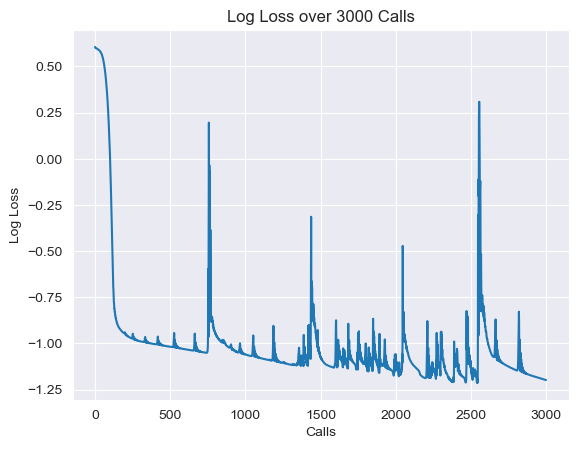

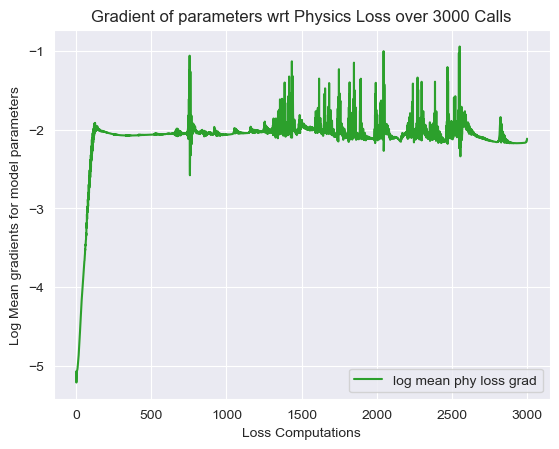

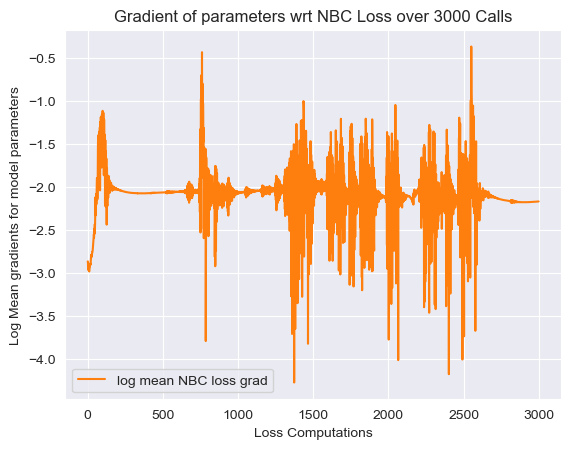

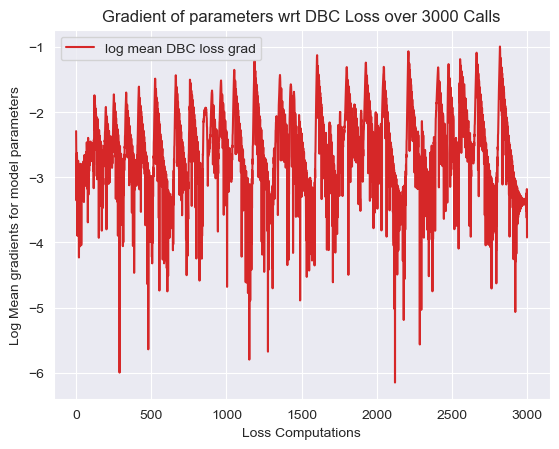

<Figure size 640x480 with 0 Axes>

In [12]:
# train
n_epochs = (3000,20)
w_update = 1
# start with Adam optimizer
optim = Adam(model.parameters())
prev_loss = list()

for epoch in range(n_epochs[0]):
    
    optim.step(closure)
    best_model_adam = checkpoint(best_model_adam)

    #if not (epoch%w_update): NBC_weight , DBC_weight = weight_update_norm(w_update)
    if not (epoch%1000): print(f'Finished epoch {epoch}, latest loss {prev_loss[-1]:.2E}')

# plot for Adam optimization stage
plot_train()

Training with L-BGFS

Finished epoch 3000, latest loss 6.19E-02
Finished epoch 3010, latest loss 2.32E-02


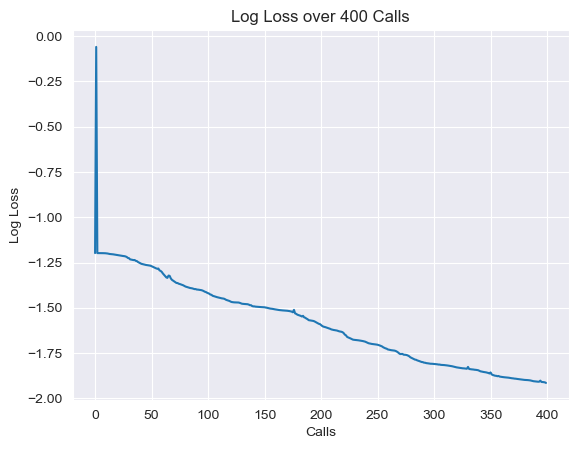

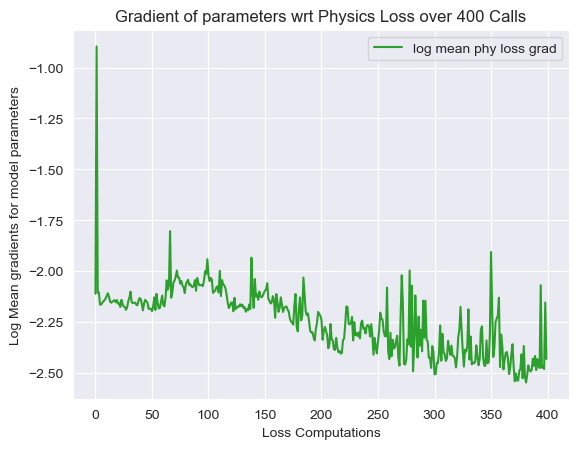

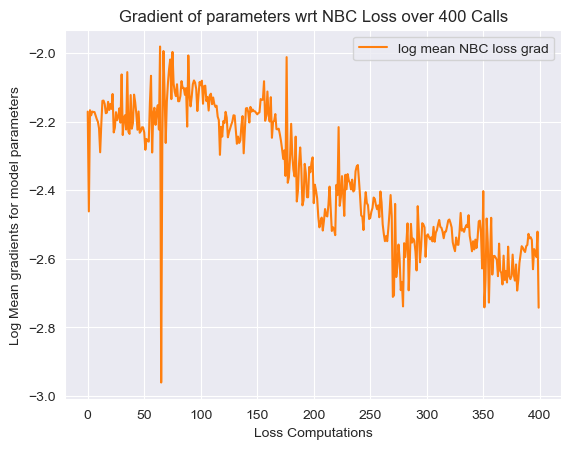

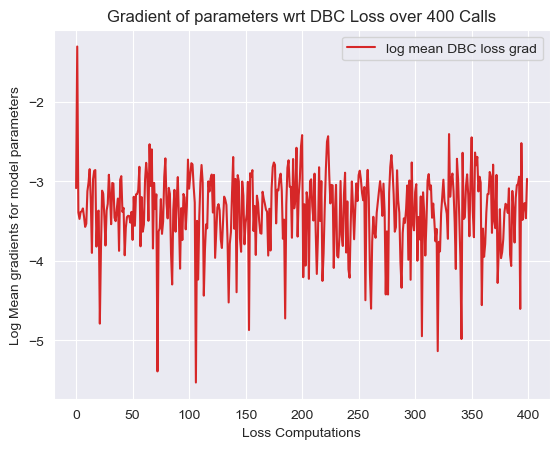

<Figure size 640x480 with 0 Axes>

In [13]:
# Change optim to L-BFGS
optim = LBFGS(model.parameters())

for epoch in range(n_epochs[0],sum(n_epochs)):
    
    optim.step(closure)
    best_model_LBFGS = checkpoint(best_model_LBFGS)

    #if not (epoch%w_update): ic_weight = weight_update_norm(w_update)
    if not (epoch%10): print(f'Finished epoch {epoch}, latest loss {prev_loss[-1]:.2E}')

plot_train(n_epochs[0])

Plot Best L-BFGS Model

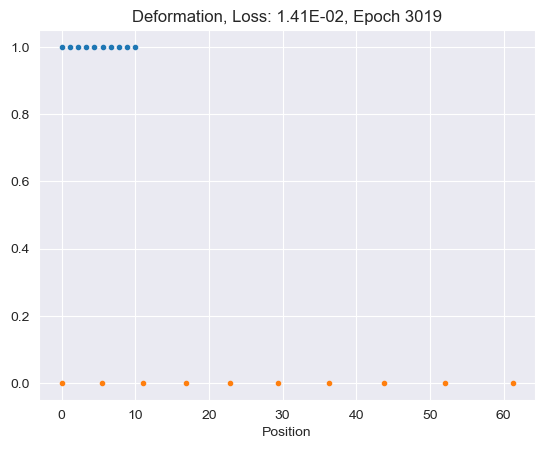

In [26]:
model.load_state_dict(best_model_LBFGS['model_state_dict'])
optim.load_state_dict(best_model_LBFGS['optimizer_state_dict'])
epoch = best_model_LBFGS['epoch']
loss = best_model_LBFGS['loss']
model.eval()

plot_comp()

Plot Best Adam Model

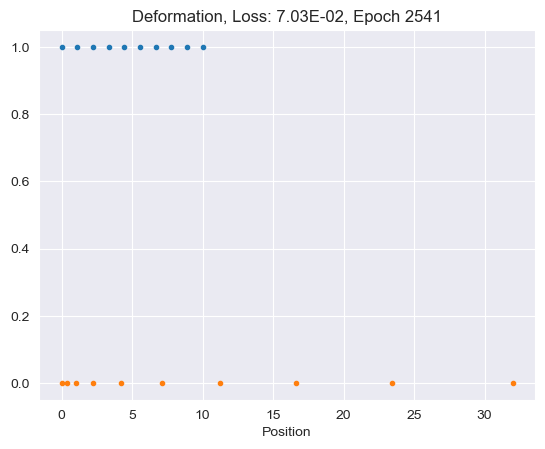

In [27]:
model.load_state_dict(best_model_adam['model_state_dict'])
optim.load_state_dict(best_model_adam['optimizer_state_dict'])
epoch = best_model_adam['epoch']
loss = best_model_adam['loss']
model.eval()

plot_comp()

Retraining wih best model using Adam

Finished epoch 3000, latest loss 7.87E-01
Finished epoch 3010, latest loss 3.97E-02


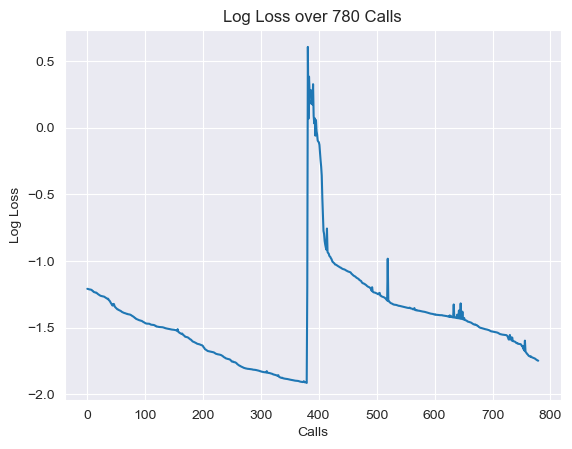

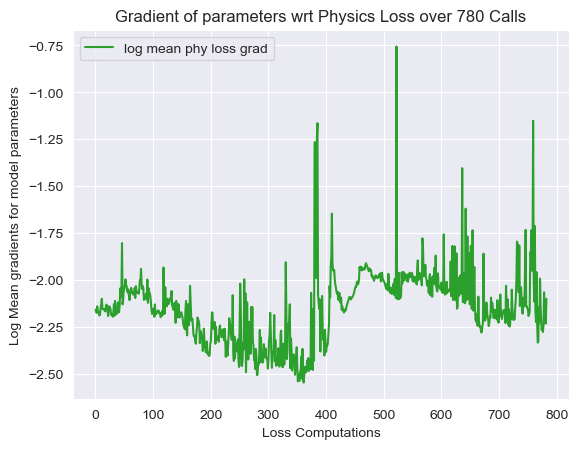

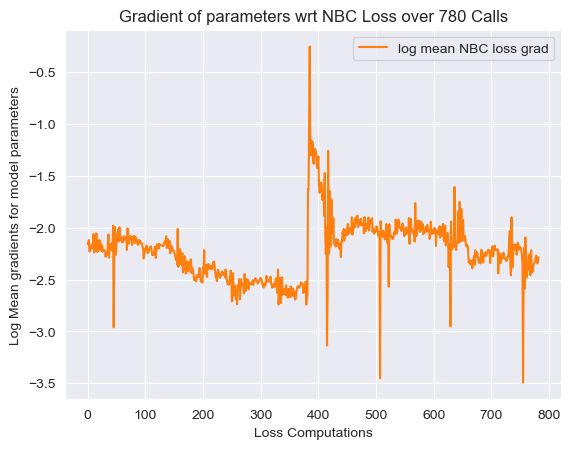

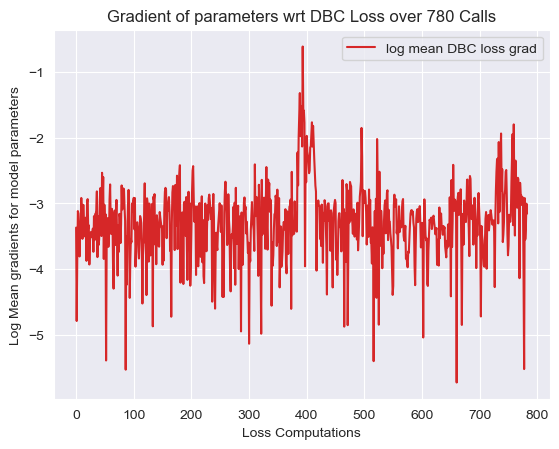

<Figure size 640x480 with 0 Axes>

In [18]:
optim = LBFGS(model.parameters())

for epoch in range(n_epochs[0],sum(n_epochs)):
    
    optim.step(closure)
    best_model_LBFGS = checkpoint(best_model_LBFGS)

    if not (epoch%w_update): ic_weight = weight_update_norm(w_update)
    if not (epoch%10): print(f'Finished epoch {epoch}, latest loss {prev_loss[-1]:.2E}')

plot_train(sum(n_epochs))

Plotting best model

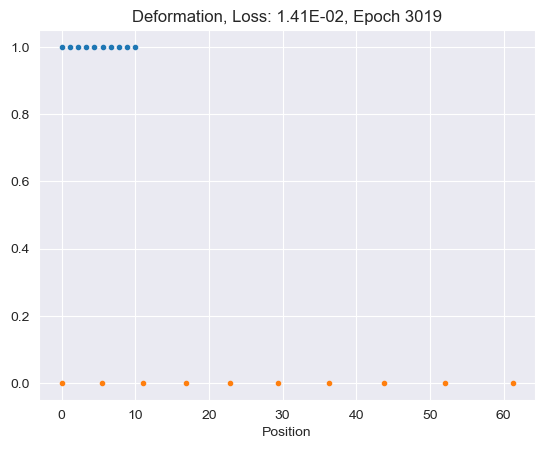

In [28]:
model.load_state_dict(best_model_LBFGS['model_state_dict'])
optim.load_state_dict(best_model_LBFGS['optimizer_state_dict'])
epoch = best_model_LBFGS['epoch']
loss = best_model_LBFGS['loss']
model.eval()

plot_comp()

Saving Best Model

In [ ]:
#model.load_state_dict(best_model['model_state_dict'])
#optim.load_state_dict(best_model['optimizer_state_dict'])
#epoch = best_model['epoch']
#loss = best_model['loss']

#PATH = f"Models\\{loss:.2E}_{epoch}.tar"
#torch.save(best_model, PATH)

Load Model

In [ ]:
#PATH = "Models\\"

#checkpoint = torch.load(PATH, map_location=device)
#model.load_state_dict(checkpoint['model_state_dict'])
#optim.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

#model.eval()
# - or -
#model.train()

#plot_comp()